<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-09/Disco-GAN/Male2Female-DiscoGAN/DiscoGAN-Male-to-Female.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Useful Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [ ]:
import tensorflow
print (tensorflow.__version__)

2.4.0


# Load and Unzip Data

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip /content/gdrive/MyDrive/GAN_datasets/face_scrub.zip -d /

In [ ]:
import glob
actors = glob.glob('/actor_faces/*/*.jpeg')
actress = glob.glob('/actress_faces/*/*.jpeg')

In [ ]:
len(actors), len(actress)

(22809, 19387)

In [ ]:
import cv2
for file in actors[:10]:
    img = cv2.imread(file)
    print (img.shape)

(239, 239, 3)
(107, 107, 3)
(169, 169, 3)
(147, 147, 3)
(449, 449, 3)
(250, 250, 3)
(615, 615, 3)
(162, 162, 3)
(345, 345, 3)
(164, 164, 3)


# Display few Samples

Male Actor Faces


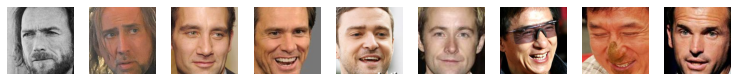

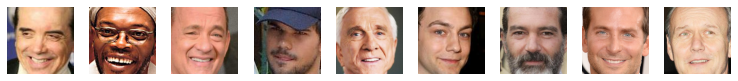

--------------------------------------------------------------------------------
Female Actress Faces


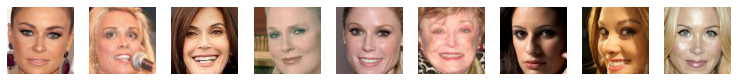

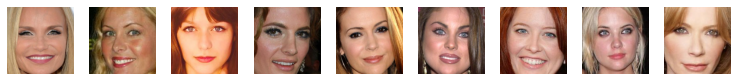

In [ ]:
print ("Male Actor Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(actors)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*80)
print ("Female Actress Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(actress)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Define Generator Model (U-Net Like)

In [ ]:
import tensorflow_addons as tfa

In [ ]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tfa.layers.InstanceNormalization()(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [ ]:
source_image_A = tensorflow.keras.layers.Input(shape=(128, 128, 3))
source_image_B = tensorflow.keras.layers.Input(shape=(128, 128, 3))

def make_generator():
    source_image = tensorflow.keras.layers.Input(shape=(128, 128, 3))

    e1 = encoder_layer(source_image, 64, bn=False)
    e2 = encoder_layer(e1, 128)
    e3 = encoder_layer(e2, 256)
    # e4 = encoder_layer(e3, 256)
    e5 = encoder_layer(e3, 512)
    e6 = encoder_layer(e5, 512)
    e7 = encoder_layer(e6, 512)

    bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
    b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

    d1 = decoder_layer(b, e7, 512)
    d2 = decoder_layer(d1, e6, 512)
    d3 = decoder_layer(d2, e5, 512)
    # d4 = decoder_layer(d3, e4, 256)
    d5 = decoder_layer(d3, e3, 256)
    d6 = decoder_layer(d5, e2, 128)
    d7 = decoder_layer(d6, e1, 64)

    decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
    translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)
    return source_image, translated_image

source_image, translated_image = make_generator()
generator_network_AB = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)

source_image, translated_image = make_generator()
generator_network_BA = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)

print (generator_network_AB.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   3136        input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 128)  131200      leaky_re_lu_1[0][0]              
______________________________________________________________________________________________

# Define Discriminator Network

In [ ]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
        x = tfa.layers.InstanceNormalization()(x)
    return x

In [ ]:
 def make_discriminator():
    target_image_input = tensorflow.keras.layers.Input(shape=(128, 128, 3))

    x = my_conv_layer(target_image_input, 64, bn=False)
    x = my_conv_layer(x, 128)
    x = my_conv_layer(x, 256)
    # x = my_conv_layer(x, 512)
    x = my_conv_layer(x, 512)

    patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)
    return target_image_input, patch_features


target_image_input, patch_features = make_discriminator()
discriminator_network_A = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

target_image_input, patch_features = make_discriminator()
discriminator_network_B = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

print (discriminator_network_A.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
instance_normalization_22 (I (None, 32, 32, 128)       256       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 256)       5245

In [ ]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network_A.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])
discriminator_network_B.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Define DISCO-GAN

In [ ]:
# Domain Transfer
fake_B = generator_network_AB(source_image_A)
fake_A = generator_network_BA(source_image_B)

# Restoring original Domain
get_back_A = generator_network_BA(fake_B)
get_back_B = generator_network_AB(fake_A)
  
discriminator_network_A.trainable=False
discriminator_network_B.trainable=False

# Tell Real vs Fake, for a given domain
verify_A = discriminator_network_A(fake_A)
verify_B = discriminator_network_B(fake_B)

disco_gan = tensorflow.keras.models.Model(inputs = [source_image_A, source_image_B], \
                              outputs = [verify_A, verify_B, fake_B, fake_A, get_back_A, get_back_B])
disco_gan.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 128, 128, 3)  41833475    input_5[0][0]                    
                                                                 model[0][0]                      
__________________________________________________________________________________________________
model (Functional)              (None, 128, 128, 3)  41833475    input_4[0][0]              

# Compiling Models

In [ ]:
disco_gan.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'], optimizer=adam_optimizer)

# Define Data Generators

In [ ]:
def actors_to_actress(actors, generator_network):
    generated_samples = generator_network.predict_on_batch(actors)
    return generated_samples

def actress_to_actors(actress, generator_network):
    generated_samples = generator_network.predict_on_batch(actress)
    return generated_samples

def get_actor_samples(batch_size):
    random_files = np.random.choice(actors, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append((img-127.5)/127.5)
    actor_images = np.array(images)
    return actor_images

def get_actress_samples(batch_size):
    random_files = np.random.choice(actress, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append((img-127.5)/127.5)
    actress_images = np.array(images)
    return actress_images

def show_generator_results_actor_to_actress(generator_network_AB, generator_network_BA):
    images = []
    for j in range(7):
        file = np.random.choice(actors)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append(img)

    print ('Input Actor Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated (Actor -> Actress) Images')
    translated = []
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = actors_to_actress(np.array([img]), generator_network_AB)[0]
        translated.append(output)
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated reverse ( Fake Actress -> Fake Actor)')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(translated):
        output = actress_to_actors(np.array([img]), generator_network_BA)[0]
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

def show_generator_results_actress_to_actor(generator_network_AB, generator_network_BA):
    images = []
    for j in range(7):
        file = np.random.choice(actress)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append(img)

    print ('Input Actress Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated (Actress -> Actor) Images')
    translated = []
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = actress_to_actors(np.array([img]), generator_network_BA)[0]
        translated.append(output)
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated reverse (Fake Actor -> Fake Actress)')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(translated):
        output = actors_to_actress(np.array([img]), generator_network_AB)[0]
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Training Disco-GAN Model

In [ ]:
len(actors), len(actress)

(22809, 19387)

In [ ]:
epochs = 500
batch_size = 1
steps = 2000

for i in range(0, epochs):
    if i%1 == 0:
        show_generator_results_actor_to_actress(generator_network_AB, generator_network_BA)
        print ("-"*100)
        show_generator_results_actress_to_actor(generator_network_AB, generator_network_BA)
    for j in range(steps):  
        # A == Actor
        # B == Actress
        domain_A_images = get_actor_samples(batch_size)
        domain_B_images = get_actress_samples(batch_size)

        fake_patch = np.zeros((batch_size, 8, 8, 1))
        real_patch = np.ones((batch_size, 8, 8, 1))
        
        fake_B_images = generator_network_AB(domain_A_images)
        fake_A_images = generator_network_BA(domain_B_images)
        
        # Updating Discriminator A weights
        discriminator_network_A.trainable=True
        discriminator_network_B.trainable=False
        loss_d_real_A = discriminator_network_A.train_on_batch(domain_A_images, real_patch)
        loss_d_fake_A = discriminator_network_A.train_on_batch(fake_A_images, fake_patch)
        
        loss_d_A = np.add(loss_d_real_A, loss_d_fake_A)/2.0
        
        # Updating Discriminator B weights
        discriminator_network_B.trainable=True
        discriminator_network_A.trainable=False
        loss_d_real_B = discriminator_network_B.train_on_batch(domain_B_images, real_patch)
        loss_d_fake_B = discriminator_network_B.train_on_batch(fake_B_images, fake_patch)
        
        loss_d_B = np.add(loss_d_real_B, loss_d_fake_B)/2.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        
        discriminator_network_A.trainable=False
        discriminator_network_B.trainable=False

        # Updating Generator weights
        loss_g = disco_gan.train_on_batch([domain_A_images, domain_B_images],\
                    [real_patch, real_patch, domain_B_images, domain_A_images, domain_A_images, domain_B_images])
        
        if j%200 == 0:
            print ("Epoch:%.0f, Step:%.0f, DA-Loss:%.3f, DA-Acc:%.3f, DB-Loss:%.3f, DB-Acc:%.3f, G-Loss:%.3f"\
                   %(i,j,loss_d_A[0],loss_d_A[1]*100,loss_d_B[0],loss_d_B[1]*100,loss_g[0]))
            